# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# 1. EDA

In [4]:
X = train.drop(labels = ["label"],axis = 1)
y = train['label']

Let's plot a random digit with its label

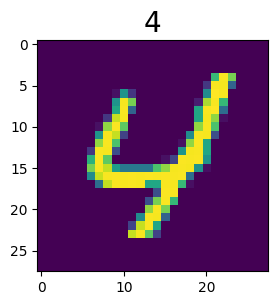

In [5]:
plt.figure(figsize=(6, 3))
i = random.randint(0, len(train))
plt.grid(False)
plt.imshow(X.iloc[i].to_numpy().reshape((28,28,1)))
plt.title(y[i],size = 20)
plt.show()

<Axes: xlabel='label', ylabel='count'>

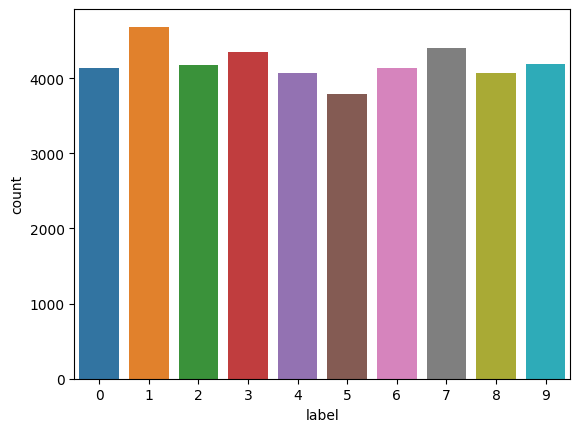

In [6]:
sns.countplot(x=y)

The label counts are well balaned.

In [7]:
print(f"Max value of pixels is : {max(X.max())}")
print(f"Min value of pixels is : {min(X.min())}")

Max value of pixels is : 255
Min value of pixels is : 0


# 2. Data preparation

Pixel values range from 0 to 255. Let's divide their value so they range from 0 to 1.

In [8]:
X_scaled = X/255
test_scaled = test/255

We'll use a CNN for digit recognition. In order to do this, we must reshape the train data matrix to (42000,28,28,1).

In [9]:
X_scaled = X_scaled.values.reshape(-1,28,28,1)
test_scaled = test_scaled.values.reshape(-1,28,28,1)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, random_state=10)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train)

# 3. Predictions

## 3.1 Method 1: CNN LeNet-5 training

The most common CNN architecture for digit recognition is **LeNet-5**. Let's create this model using TensorFlow's Sequential API.

In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=1000),
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/30


I0000 00:00:1738679683.886425      95 service.cc:145] XLA service 0x798a000074f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738679683.886481      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1738679683.886485      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3:24 7s/step - accuracy: 0.0760 - loss: 2.2984

I0000 00:00:1738679687.160806      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step - accuracy: 0.4701 - loss: 1.7765 - val_accuracy: 0.9097 - val_loss: 0.3213
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.8197 - loss: 0.5892 - val_accuracy: 0.9553 - val_loss: 0.1559
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9033 - loss: 0.3266 - val_accuracy: 0.9633 - val_loss: 0.1233
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9254 - loss: 0.2431 - val_accuracy: 0.9724 - val_loss: 0.0930
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9391 - loss: 0.2020 - val_accuracy: 0.9748 - val_loss: 0.0794
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.9502 - loss: 0.1708 - val_accuracy: 0.9775 - val_loss: 0.0701
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9529 - loss: 0.1492 - val_accuracy: 0.9807 - val_loss: 0.0632
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.9597 - loss: 0.1339 - val_accuracy: 0.9799 - val

In [16]:
print(f"Loss     : {history.history['loss'][-1]}")
print(f"Accuracy : {history.history['accuracy'][-1]}")

Loss     : 0.05889052897691727
Accuracy : 0.9813968539237976


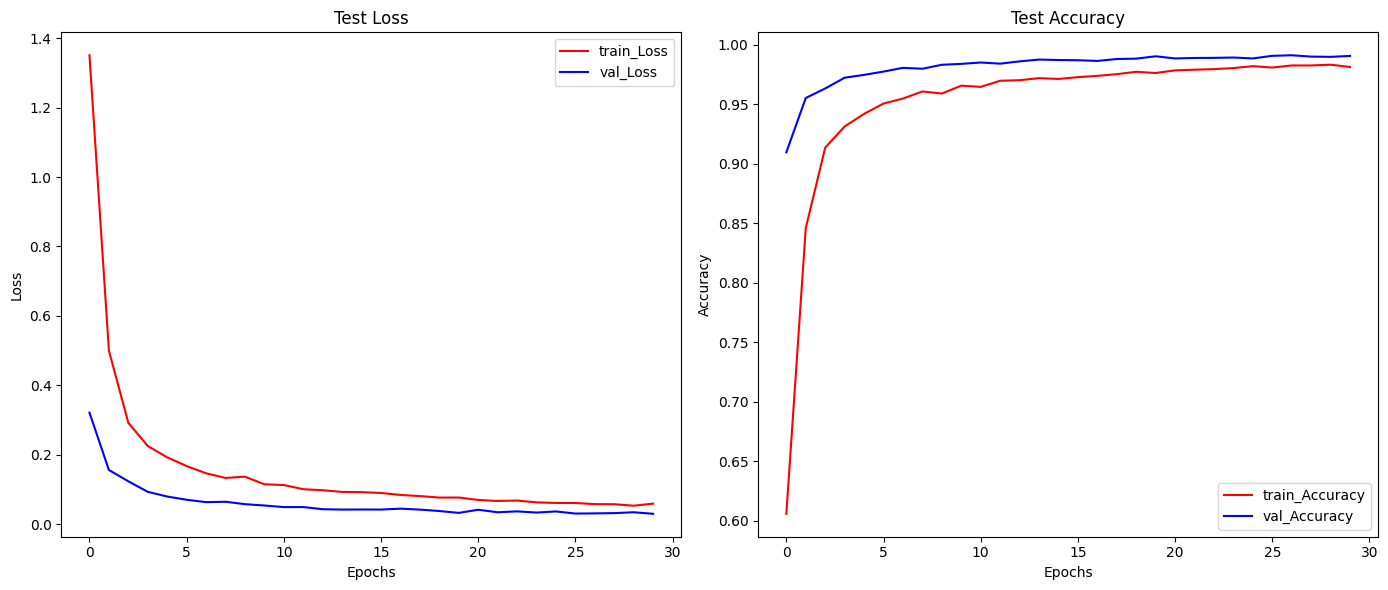

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))

ax1.plot(history.history['loss'], color='r', label="train_Loss")
ax1.plot(history.history['val_loss'], color='b', label="val_Loss")
ax1.legend()
ax1.set_title("Test Loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")

ax2.plot(history.history['accuracy'], color='r', label="train_Accuracy")
ax2.plot(history.history['val_accuracy'], color='b', label="val_Accuracy")
ax2.legend()
ax2.set_title("Test Accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epochs")
fig.tight_layout()

In [18]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


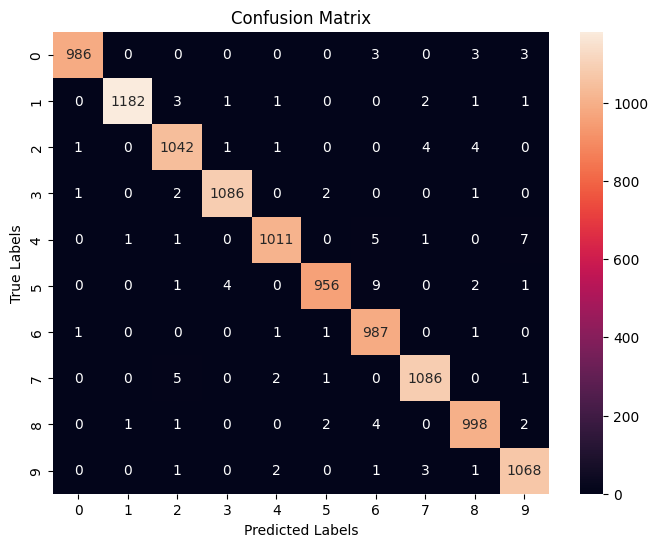

In [19]:
conf_matrix = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 4. Submission

In [28]:
y_sub = model.predict(test_scaled)
y_sub_labels = np.argmax(y_sub, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [29]:
submission = pd.DataFrame({'ImageId': range(1,28001), 'Label': y_sub_labels})
submission.to_csv('submission.csv', index=False)